In [7]:
# Re-establishing the paths after reset
zip_path_new = '/content/new-20250130T145619Z-001.zip'
extracted_folder_new = '/content/extracted_dataset_new'

# Import the ZipFile class or use the fully qualified name
from zipfile import ZipFile # Importing the ZipFile class

# Extract the zip file
with ZipFile(zip_path_new, 'r') as zip_ref: # Now, ZipFile is recognized.
    zip_ref.extractall(extracted_folder_new)

# List the contents of the extracted folder to confirm the structure
extracted_contents_new = os.listdir(extracted_folder_new)
extracted_contents_new

['new']

In [16]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [17]:
train_dir = '/content/extracted_dataset_new/new/train'
test_dir = '/content/extracted_dataset_new/new/test'

In [18]:
# Step 1: Data Preparation with validation split
def prepare_data(train_dir, test_dir, target_size=(224, 224), batch_size=32):
    # Calculate class weights from original training data
    menin_count = len(os.listdir(os.path.join(train_dir, 'brain_menin')))
    glioma_count = len(os.listdir(os.path.join(train_dir, 'brain_glioma')))
    total = menin_count + glioma_count
    class_weights = {
        0: total / (2 * menin_count),  # Menin
        1: total / (2 * glioma_count)   # Glioma
    }

    # Data augmentation for training
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.3,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=0.2  # 20% for validation
    )

    # Validation generator
    val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Train generator
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training',
        shuffle=True
    )

    # Validation generator
    val_generator = val_datagen.flow_from_directory(
        train_dir,  # Same directory as training
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

    # Test generator
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator, class_weights

In [27]:
# This function was previously missing, causing the NameError
def build_model():
    from tensorflow.keras.applications import DenseNet121
    from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
    from tensorflow.keras.models import Model

    # Load the DenseNet121 model pre-trained on ImageNet data
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)  # Add a dense layer
    # Change the number of units to match the number of classes and use softmax activation
    predictions = Dense(3, activation='softmax')(x)  # Final layer for multi-class classification

    # Combine into a final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    # Use categorical_crossentropy for multi-class classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model # Return the model

In [28]:
# Step 3: Training and Fine tuning
def train_model(model, train_gen, val_gen, class_weights, initial_epochs=10, fine_tune_epochs=20):
    # Phase 1: Train the head
    model.compile(optimizer=Adam(1e-3),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    print("\nTraining classifier head")
    history = model.fit(
        train_gen,
        epochs=initial_epochs,
        validation_data=val_gen,
        class_weight=class_weights
    )

    # Phase 2: Fine tune the model
    model.trainable = True
    for layer in model.layers[:len(model.layers)//2]:
        layer.trainable = False  # Freeze first half of the model

    model.compile(optimizer=Adam(1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(), Recall()])

    print("\nFine-tuning entire model")
    history_fine = model.fit(
        train_gen,
        epochs=initial_epochs + fine_tune_epochs,
        initial_epoch=history.epoch[-1] + 1,
        validation_data=val_gen,
        class_weight=class_weights
    )

    return history, history_fine

In [29]:
# Step 4: Evaluation and Visualization
def evaluate_model(model, test_gen):
    # Evaluate metrics
    results = model.evaluate(test_gen)
    print(f"Test Loss: {results[0]:.3f}")
    print(f"Test Accuracy: {results[1]:.3f}")
    print(f"Test Precision: {results[2]:.3f}")
    print(f"Test Recall: {results[3]:.3f}")

    # Confusion matrix
    y_true = test_gen.classes
    y_pred = np.argmax(model.predict(test_gen), axis=1)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Menin', 'Glioma'],
                yticklabels=['Menin', 'Glioma'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=['Menin', 'Glioma']))

Found 670 images belonging to 3 classes.
Found 167 images belonging to 3 classes.
Found 210 images belonging to 3 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_6          │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_6[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_7          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_7[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 8,090,179 (30.86 MB)

 Trainable params: 1,052,675 (4.02 MB)

 Non-trainable params: 7,037,504 (26.85 MB)


Training classifier head


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 173s 8s/step - accuracy: 0.8036 - loss: 4.5277 - precision_1: 0.8159 - recall_1: 0.8036 - val_accuracy: 0.9581 - val_loss: 1.8097 - val_precision_1: 0.9581 - val_recall_1: 0.9581
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 144s 7s/step - accuracy: 0.9600 - loss: 0.7337 - precision_1: 0.9600 - recall_1: 0.9600 - val_accuracy: 0.9581 - val_loss: 0.4284 - val_precision_1: 0.9581 - val_recall_1: 0.9581
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 200s 7s/step - accuracy: 0.9518 - loss: 0.1959 - precision_1: 0.9518 - recall_1: 0.9518 - val_accuracy: 0.9581 - val_loss: 0.2453 - val_precision_1: 0.9581 - val_recall_1: 0.9581
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 142s 7s/step - accuracy: 0.9507 - loss: 0.1321 - precision_1: 0.9507 - recall_1: 0.9507 - val_accuracy: 0.9581 - val_loss: 0.1468 - val_precision_1: 0.9581 - val_recall_1: 0.9581
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 165s 8s/step - accuracy: 0.9626 - loss: 0.0940 - precision_1: 0.9626 - recall_1: 0.9626 - val_

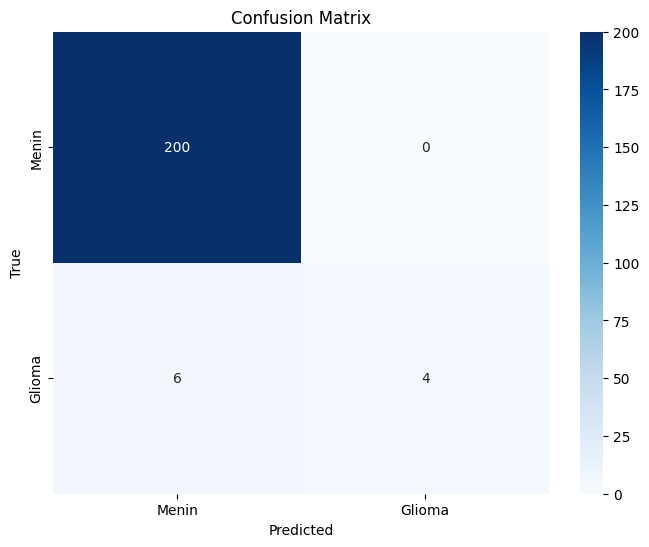


Classification Report:
              precision    recall  f1-score   support

       Menin       0.97      1.00      0.99       200
      Glioma       1.00      0.40      0.57        10

    accuracy                           0.97       210
   macro avg       0.99      0.70      0.78       210
weighted avg       0.97      0.97      0.97       210

Model saved successfully


In [30]:
# Main Execution
if __name__ == "__main__":
    # Set paths
    train_dir = '/content/extracted_dataset_new/new/train'
    test_dir = '/content/extracted_dataset_new/new/test'

    # Prepare data
    train_gen, val_gen, test_gen, class_weights = prepare_data(train_dir, test_dir)

    # Build model
    model = build_model()
    model.summary()

    # Train model
    history, history_fine = train_model(model, train_gen, val_gen, class_weights)

    # Evaluate model
    evaluate_model(model, test_gen)

    # Save model
    model.save('brain_tumor_classifier.keras')
    print("Model saved successfully")